In [6]:
# How to validate ongoing learning?

# Here implemented method:
# - load current model
# - simulate a number of games with random moves initially to get random positions
# - played out deterministically based on current model
# - calculate mean difference between model values and what would be the MC-reward (discounted -1 / 1)
# - keep track of these errors for either only decisive games or all games

In [7]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v9
from Resources.Game import *


In [8]:
model = Model_v9()
model_saves = os.listdir('../Monte Carlo/Model Saves MC v9')
if len(model_saves) > 0:
    newest_model = max(int(i[6:-8]) for i in model_saves)
    latest_batch_index = newest_model
    model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v9/model_{}_batches'.format(newest_model)))
criterion = nn.MSELoss()

n_games         = 25 # number of games per model load
n_random_moves  = 5 # number of random moves per player in the beginning
use_draws       = False
gamma           = 0.98 

draws           = 0
white_wins      = 0
black_wins      = 0

In [9]:
model_saves = os.listdir('../Monte Carlo/Model Saves MC v9')
model_inds = [int(i[6:-8]) for i in model_saves]
model_inds.sort()

val_mean_list = []
val_median_list = []
val_std_list = []

current_model_ind = 0

while True:

    # wait for new data

    model = Model_v9()
    model_saves = os.listdir('../Monte Carlo/Model Saves MC v9')
    if len(model_saves) > 0:
        newest_model = max(int(i[6:-8]) for i in model_saves)
        latest_batch_index = newest_model
        if latest_batch_index > current_model_ind:
            model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v9/model_{}_batches'.format(newest_model)))
            current_model_ind = latest_batch_index
        else:
            time.sleep(0.05)
            continue
    else:
        time.sleep(0.05)
        continue
            
    validation_error_list = []

    i_game = 0
    while i_game < n_games:

        # if (white_wins + black_wins + draws) % 10 == 0:
        #     print('game {}, w: {}, b: {}, d: {}'.format(i_game, white_wins, black_wins, draws))

        game = Game()
        i = 0
        boards_white = [];  boards_black = []
        values_white = [];  values_black = []

        model.eval()

        while not game.is_over():
            
            i += 1
            moves = game.PossibleMoves()

            game_ini = game.copy()

            # value of initial board is not needed for validation
            # board_batch = [board_to_tensor(game.pieces)]
            board_batch = []

            # initial random moves to get interesting position, dont save these
            if i <= n_random_moves * 2:
                chosen_ind = np.random.choice(range(len(moves)))
                chosen_move = moves[chosen_ind]
                game.PlayMove(chosen_move)
                game.FlipBoard()
                continue

            mate = False

            # if move can win, play that move
            for move in moves:
                game.PlayMove(move)
                board_batch.append(board_to_tensor(game.pieces))
                game.FlipBoard()
                if game.is_over():
                    mate = True
                    chosen_move = move
                    game = game_ini.copy()
                    break
                game = game_ini.copy()

            # play move that get highest value
            if not mate:
                board_tensor = torch.stack(board_batch)
                values = model(board_tensor)
                max_ind = torch.argmax(values).item()
                chosen_move = moves[max_ind]
                max_value = values[max_ind]
                
            game.PlayMove(chosen_move)

            # if move is mate, value has not yet been calculated, but is still necessary for validation
            if mate:
                max_value = model(torch.stack([board_to_tensor(game.pieces)]))

            if i % 2 == 1:
                boards_white.append(board_to_bool_tensor(game.pieces))
                values_white.append(max_value)
            if i % 2 == 0:
                boards_black.append(board_to_bool_tensor(game.pieces))
                values_black.append(max_value)

            game.FlipBoard()
        
        winner = game.get_winner()

        if winner == 'draw':
            draws += 1
            if not use_draws:
                # n_games += 1
                continue
            reward_white = 0;   reward_black = 0

        elif winner == 'white':
            white_wins += 1
            reward_white = 1;   reward_black = -1

        elif winner == 'black':
            black_wins += 1
            reward_white = -1;  reward_black = 1

        labels_white = [reward_white * gamma**(len(boards_white) - 1 - i) for i in range(len(boards_white))]
        labels_black = [reward_black * gamma**(len(boards_black) - 1 - i) for i in range(len(boards_black))]

        # inputs_tens = torch.stack(boards_white + boards_black)
        labels_tens = torch.Tensor(labels_white + labels_black)
        values_tens = torch.Tensor(values_white + values_black)

        # plt.plot(labels_tens.detach().numpy(), label='labels')
        # plt.plot(values_tens.detach().numpy(), label='values')
        # plt.legend()
        # plt.show()

        validation_error = criterion(labels_tens, values_tens)
        # print(validation_error.item)
        validation_error_list.append(validation_error)

        i_game += 1
    
    val_mean_list.append(np.mean(validation_error_list))
    val_median_list.append(np.median(validation_error_list))
    val_std_list.append(np.std(validation_error_list))

    print('validation error for model {}: '.format(current_model_ind))
    print('mean error = ', np.mean(validation_error_list))
    print('median error = ', np.median(validation_error_list))
    print('std error = ', np.std(validation_error_list))

    plt.plot(val_mean_list)
    plt.plot(val_median_list)
    plt.show()
    

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

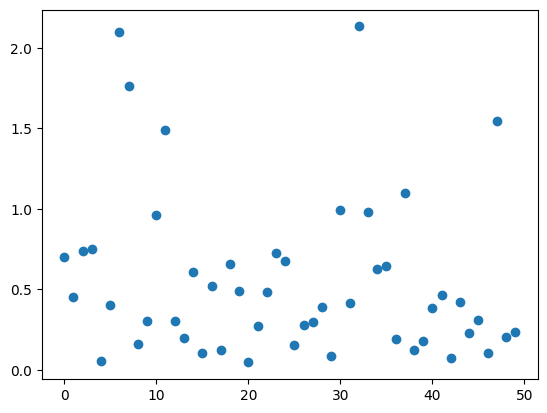

In [51]:
plt.scatter(range(len(validation_error_list)), validation_error_list)
plt.show()

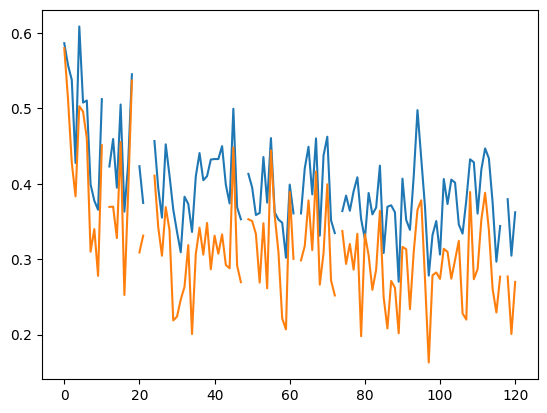

In [26]:
plt.plot(val_mean_list)
plt.plot(val_median_list)
plt.show()